In [42]:
# !pip install regex pandas scikit-learn numpy wordcloud matplotlib seaborn nltk gensim torch

### Importing libraries

In [43]:
import os
import re
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [44]:
base_dirt = os.getcwd()
path = os.path.join(base_dirt, 'dataset/p3_data.csv')
data = pd.read_csv(path, encoding='ISO-8859-1')

In [45]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


### Data explore

In [46]:
corpus = data[['OriginalTweet','Sentiment']]

In [47]:
corpus.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [48]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


In [49]:
corpus.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [50]:
corpus['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [51]:
encoder = OrdinalEncoder(categories=[['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']])
corpus['Sentiment'] = encoder.fit_transform(corpus[['Sentiment']])

C:\Users\Asus\AppData\Local\Temp\ipykernel_1036\4240578442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['Sentiment'] = encoder.fit_transform(corpus[['Sentiment']])


In [52]:
corpus['Sentiment'].value_counts()

Sentiment
3.0    11422
1.0     9917
2.0     7713
4.0     6624
0.0     5481
Name: count, dtype: int64

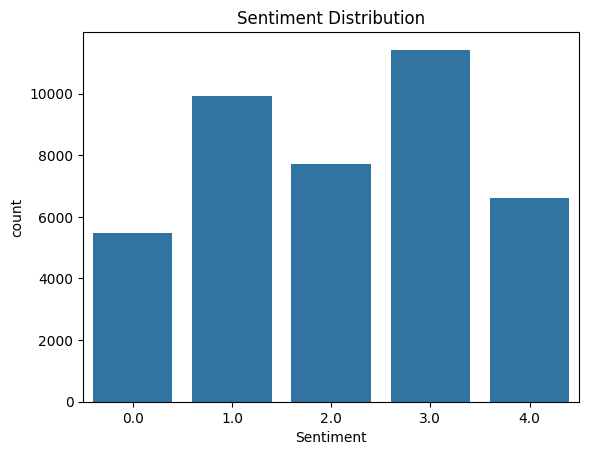

In [53]:
sns.countplot(x='Sentiment', data=corpus)
plt.title('Sentiment Distribution')
plt.show()

In [54]:
corpus['OriginalTweet'].sample(10).values

array(['ItÂ\x92s interesting to see the amount of people flat out ignoring the limits. \r\r\n\r\r\nThereÂ\x92s a limit of 2 Susan!\r\r\n#groceryshopping #coronavirus #StopPanicBuying',
       'Helpful information on issues of the moment: travel, events, scams, employment, schools https://t.co/6ck5mmqt1x \r\r\n@CitizensAdvice',
       '#coronavirus #coronavirusindia #coronavirusinindia Coronavirus Impact on India: Prices of #Vegetables And #Fruits Increase in Cities Under Lockdown Amid #COVID?19 #Covid_19india COVID-19 Pandemic https://t.co/8P0unsylSV',
       'Got two 6 packs of   the store limit at Aldi at 9 am Feeling so successful I gave some dude my cart and let him keep my quarter   Thank you to grocery and retail workers who I also consider to be on the front lines during all of this',
       "The coronavirus pandemic has slowed down the economy as well as the consumer buying behaviour, so if you are thinking to start a business right now it might won't work. So this is the exact

### Cleaning words sentences using regular expression

In [55]:
def clean_tweet(tweet):
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#\w+', '', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    
    return tweet

corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(clean_tweet)


C:\Users\Asus\AppData\Local\Temp\ipykernel_1036\2179563702.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(clean_tweet)


In [56]:
corpus['OriginalTweet'].sample(10).values

array(['Cant get if you drink a whole bottle of hand sanitizer',
       'Perception panic vs reported reality of via',
       'Shopping for elderly people delivering groceries to refugees and showing free online theatrical performances COVID is spreading fast but so is the volunteer movement to help combat it reports',
       'due to is not limited to supermarkets and pharmacies While food flies off shelves others with a survivalist bent are on a mission to purchase firearms Learn more via VIA',
       'Downscaling polluting industries and consumer culture are inevitable but the response to climate catastrophe is being constantly postponed Now with on our heels there is no remind me tomorrow',
       'Roughly half of US consumer spending activity is highly exposed to risk via',
       'Vulnerable people isolating from Covid cannot book food deliveries because all the delivery slots have been taken by others who can get out to go SHOPPING My husband and I and our Son are in the Vulnerab

### Removing Stopwords

In [57]:
corpus['OriginalTweet'] = corpus['OriginalTweet'].str.lower()

C:\Users\Asus\AppData\Local\Temp\ipykernel_1036\892715711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['OriginalTweet'] = corpus['OriginalTweet'].str.lower()


In [58]:
nltk.download('stopwords')

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    new_text = []

    for word in words:
        if word not in stop_words:
            new_text.append(word)
    
    return ' '.join(new_text)

corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(remove_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Asus\AppData\Local\Temp\ipykernel_1036\2800391941.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(remove_stop_words)


### WordCloud Visualization

In [59]:
def get_words(df, sentiment, n=10):
    sentiment_df = df[df['Sentiment'] == sentiment]

    all_words = []
    for tokens in sentiment_df['OriginalTweet']:
        for word in tokens.split():
            all_words.append(word)

    top_words = Counter(all_words).most_common(n)
    return dict(top_words)

positive_words = get_words(corpus, 3.0 , 10)
negative_words = get_words(corpus, 1.0, 10)
neutral_words = get_words(corpus, 2.0, 10)
extremely_positive_words = get_words(corpus, 4.0, 10)
extremely_negative_words = get_words(corpus, 0.0, 10)

print("Top 10 Extremely Positive Words:", extremely_positive_words)
print("Top 10 Positive Words:", positive_words)
print("Top 10 Neutral Words:", neutral_words)
print("Top 10 Negative Words:", negative_words)
print("Top 10 Extremely Negative Words:", extremely_negative_words)

Top 10 Extremely Positive Words: {'covid': 1655, 'store': 1258, 'amp': 1123, 'grocery': 1053, 'supermarket': 1032, 'help': 972, 'food': 961, 'hand': 938, 'prices': 931, 'sanitizer': 833}
Top 10 Positive Words: {'covid': 2933, 'store': 2014, 'prices': 2014, 'grocery': 1868, 'supermarket': 1814, 'food': 1718, 'people': 1429, 'amp': 1421, 'consumer': 1241, 'online': 1057}
Top 10 Neutral Words: {'covid': 1742, 'store': 1304, 'supermarket': 1241, 'prices': 1191, 'grocery': 1122, 'consumer': 904, 'shopping': 678, 'online': 666, 'food': 609, 'people': 599}
Top 10 Negative Words: {'covid': 2613, 'prices': 2350, 'food': 1941, 'supermarket': 1644, 'store': 1519, 'people': 1412, 'grocery': 1384, 'amp': 1078, 'consumer': 913, 'demand': 881}
Top 10 Extremely Negative Words: {'covid': 1539, 'food': 1531, 'prices': 1335, 'people': 1212, 'panic': 1137, 'supermarket': 902, 'crisis': 833, 'amp': 827, 'store': 662, 'buying': 646}


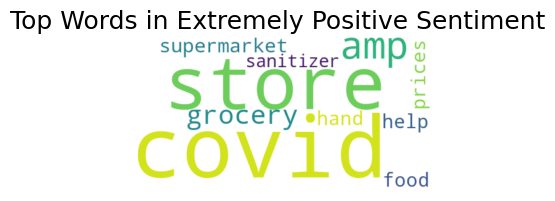

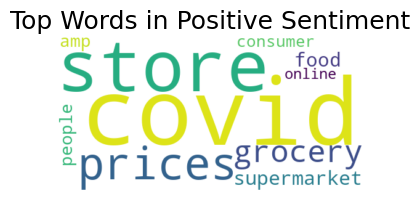

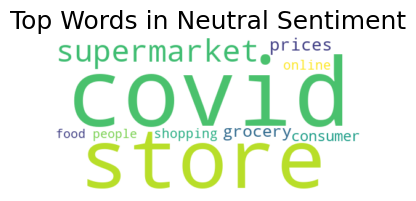

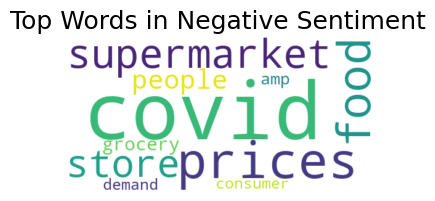

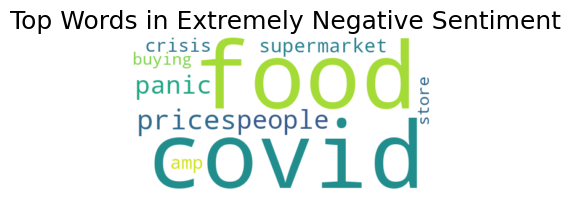

In [60]:
def plot_wordcloud(word_freq, title):
    wordcloud = WordCloud(width=500, height=250, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(4, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.show()

plot_wordcloud(extremely_positive_words, 'Top Words in Extremely Positive Sentiment')
plot_wordcloud(positive_words, 'Top Words in Positive Sentiment')
plot_wordcloud(neutral_words, 'Top Words in Neutral Sentiment')
plot_wordcloud(negative_words, 'Top Words in Negative Sentiment')
plot_wordcloud(extremely_negative_words, 'Top Words in Extremely Negative Sentiment')

In [61]:
from nltk import ngrams

def class_ngrams(tokens, n):
    return list(ngrams(tokens, n))

def plot_ngrams(ngrams, title):
    ngram_labels = [' '.join(ngram[0]) for ngram in ngrams]
    ngram_counts = [ngram[1] for ngram in ngrams]
    
    plt.figure(figsize=(10, 6))
    plt.barh(ngram_labels, ngram_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

### Data spiliting

In [62]:
x = corpus['OriginalTweet']
y = corpus['Sentiment']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=100)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=100)

In [63]:
x_train

10214    banks pressure health care firms raise prices ...
29228    supermarket hasnt put one person per family ru...
34964    heyday another household staple frequently get...
11280         creating problems need clear messages backed
26017    oil prices low theyre low paying cents gallon ...
                               ...                        
24052    situation worsening evryday prices commodities...
22491    central ohio food pantries among feeling strai...
39017    breaking opec oil nations agree nearly million...
5999     pandemic unleashed waves week meat front centr...
19045    looking support mum shes emergency accommodati...
Name: OriginalTweet, Length: 33336, dtype: object

### Tokenization

In [64]:
nltk.download('punkt_tab')
x_train = x_train.apply(word_tokenize)
x_test = x_test.apply(word_tokenize)
x_cal = x_val.apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [65]:
x_train

10214    [banks, pressure, health, care, firms, raise, ...
29228    [supermarket, hasnt, put, one, person, per, fa...
34964    [heyday, another, household, staple, frequentl...
11280    [creating, problems, need, clear, messages, ba...
26017    [oil, prices, low, theyre, low, paying, cents,...
                               ...                        
24052    [situation, worsening, evryday, prices, commod...
22491    [central, ohio, food, pantries, among, feeling...
39017    [breaking, opec, oil, nations, agree, nearly, ...
5999     [pandemic, unleashed, waves, week, meat, front...
19045    [looking, support, mum, shes, emergency, accom...
Name: OriginalTweet, Length: 33336, dtype: object

### Data visualization

Maximum length of each instances: 40


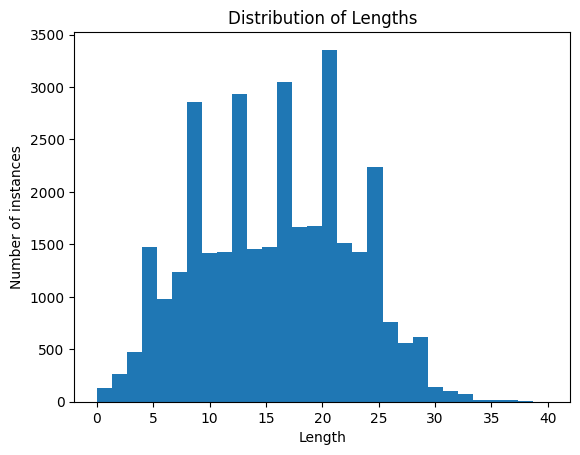

In [66]:
length = [len(token) for token in x_train]
print(f'Maximum length of each instances: {max(length)}')

plt.hist(length, bins=30)
plt.xlabel('Length')
plt.ylabel('Number of instances')
plt.title('Distribution of Lengths')
plt.show()

### word2vec model train

In [67]:
'''
whole_x = pd.concat([x_train, x_test, x_val])

word2vec_model = Word2Vec(
    sentences= whole_x,
    vector_size= 300,
    window= 10,
    min_count= 1,
    workers= 4,
    sg= 0
)

word2vec_model.build_vocab(x_train)
word2vec_model.train(x_train, total_examples=word2vec_model.corpus_count, epochs=30)

word2vec_model.save("weights/word2vec_weight.model")
'''


'\nwhole_x = pd.concat([x_train, x_test, x_val])\n\nword2vec_model = Word2Vec(\n    sentences= whole_x,\n    vector_size= 300,\n    window= 10,\n    min_count= 1,\n    workers= 4,\n    sg= 0\n)\n\nword2vec_model.build_vocab(x_train)\nword2vec_model.train(x_train, total_examples=word2vec_model.corpus_count, epochs=30)\n\nword2vec_model.save("weights/word2vec_weight.model")\n'

In [68]:
word2vec_model = Word2Vec.load('weights/word2vec_weight.model')

### Converting each sentence to (len(sentence)* 300) matrix
##### If a instance has 20 tokens, it will have (20* 300) matrix

In [69]:
def vectorize_sentence(sentence, model):
    vectors = []
    for word in sentence:
        if word in model.wv:
            vectors.append(model.wv[word]) 
    return vectors

x_train = x_train.apply(lambda tokens: vectorize_sentence(tokens, word2vec_model))
x_test = x_test.apply(lambda tokens: vectorize_sentence(tokens, word2vec_model))
x_val= x_val.apply(lambda tokens: vectorize_sentence(tokens, word2vec_model))

In [70]:
# each vector size = len(x_train[index]) * 100

x_train[3]

[array([-8.77380893e-02,  6.11262858e-01,  3.92032266e-01, -5.62262774e-01,
        -1.28717929e-01,  1.38936591e+00,  6.96336567e-01,  2.93370068e-01,
         5.61978579e-01, -2.54899073e+00,  1.01050806e+00, -1.30028749e+00,
        -7.81010985e-01,  3.06568146e-01, -6.47132933e-01,  5.38441874e-02,
         9.56085980e-01, -6.41840279e-01, -1.20851481e+00,  7.15181887e-01,
        -6.12918556e-01, -1.74361080e-01, -1.74230838e+00, -6.89583570e-02,
         3.01829278e-01,  5.75156808e-01,  5.51062644e-01, -2.28586290e-02,
         3.62578750e-01,  7.45961189e-01, -3.19728804e+00,  2.87579834e-01,
         2.53126830e-01, -1.87689900e+00, -1.25957775e+00,  7.81677425e-01,
         1.19988352e-01, -9.56368633e-03,  5.54094672e-01,  7.17014432e-01,
        -1.76474106e+00, -7.15442419e-01,  1.33628690e+00, -1.54940188e-01,
        -4.98429984e-01, -1.05579638e+00,  2.19025993e+00, -6.95634663e-01,
        -1.10045373e+00,  9.35363889e-01,  2.78926373e-01,  1.84634089e+00,
        -1.2

In [71]:
def vector_lengths(data):
    vec_len = {}
    for vec in data:
        if len(vec) not in vec_len:
            vec_len[len(vec)] = 1
        else:
            vec_len[len(vec)] += 1

    return vec_len

In [72]:
print(f'Train: {vector_lengths(x_train)}')
print(f'Validation: {vector_lengths(x_val)}')
print(f'Test: {vector_lengths(x_test)}')

Train: {12: 1484, 9: 1440, 11: 1425, 6: 983, 16: 1477, 5: 872, 10: 1413, 17: 1575, 20: 1694, 18: 1666, 15: 1471, 3: 473, 8: 1412, 27: 564, 25: 1047, 4: 604, 23: 1423, 14: 1452, 22: 1516, 30: 138, 21: 1661, 34: 15, 24: 1194, 7: 1234, 19: 1671, 26: 757, 2: 268, 13: 1446, 29: 237, 28: 382, 1: 92, 32: 50, 33: 26, 31: 99, 35: 15, 0: 41, 37: 3, 40: 1, 36: 12, 38: 3}
Validation: {88: 19, 12: 22, 56: 59, 69: 54, 59: 50, 79: 42, 72: 42, 53: 38, 102: 2, 60: 68, 76: 49, 20: 55, 24: 35, 81: 54, 40: 55, 49: 54, 17: 33, 68: 61, 54: 44, 98: 11, 44: 48, 65: 61, 26: 44, 32: 49, 48: 54, 87: 23, 50: 47, 85: 30, 13: 19, 90: 22, 51: 55, 42: 38, 73: 50, 23: 47, 29: 54, 89: 16, 25: 38, 61: 48, 63: 53, 97: 10, 101: 6, 57: 56, 77: 42, 22: 50, 91: 25, 39: 45, 64: 55, 66: 36, 38: 45, 33: 52, 84: 23, 67: 57, 46: 59, 31: 45, 80: 41, 74: 49, 6: 9, 78: 33, 19: 35, 52: 45, 47: 60, 18: 27, 28: 40, 9: 8, 86: 25, 30: 44, 34: 57, 41: 51, 14: 32, 71: 50, 92: 13, 27: 52, 45: 46, 58: 43, 70: 62, 82: 45, 7: 16, 75: 43, 10: 1

### Padding the sentences

In [73]:
train_max_len = max(vector_lengths(x_train))
val_max_len = max(vector_lengths(x_val))
test_max_len = max(vector_lengths(x_test))

def pad_sequence(sequence, max_len):
    if len(sequence) < max_len:
        padding = [np.zeros(300)] * (max_len - len(sequence))
        return sequence + padding
    
    return sequence

x_train = x_train.apply(lambda x: pad_sequence(x, train_max_len))
x_val = x_val.apply(lambda x: pad_sequence(x, val_max_len))
x_test = x_test.apply(lambda x: pad_sequence(x, test_max_len))

### Convert to Tensor

In [74]:
print(x_train.dtypes)
print(y_train.dtypes)

object
float64


In [75]:
print(f'Train: {vector_lengths(x_train)}')
print(f'Validation: {vector_lengths(x_val)}')
print(f'Test: {vector_lengths(x_test)}')

Train: {40: 33336}
Validation: {117: 3705}
Test: {36: 4116}


In [76]:
x_train_tensor = torch.tensor(x_train.tolist(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.long)
x_val_tensor = torch.tensor(x_val.tolist(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.tolist(), dtype=torch.long)
x_test_tensor = torch.tensor(x_test.tolist(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [77]:
print(x_train_tensor.size())
print(x_val_tensor.size())
print(x_test_tensor.size())

torch.Size([33336, 40, 300])
torch.Size([3705, 117, 300])
torch.Size([4116, 36, 300])


In [78]:
print(y_train_tensor.unique())
print(y_val_tensor.unique())
print(y_test_tensor.unique())

tensor([0, 1, 2, 3, 4])
tensor([0, 1, 2, 3, 4])
tensor([0, 1, 2, 3, 4])


### LSTM Model

In [79]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [80]:
def calculate_accuracy(y_pred, y_true):
    y_pred_tag = torch.argmax(y_pred, dim=1)
    correct_results_sum = (y_pred_tag == y_true).sum().float()
    acc = correct_results_sum / y_true.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [81]:
input_size = 300
hidden_size = 128
output_size = 5
num_layers = 8

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [82]:
train_losses = []
val_losses = []
test_losses = []

train_accuracy = []
val_accuracy = []
test_accuracy = []

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += calculate_accuracy(outputs, batch_y)
    
    model.eval()
    val_loss = 0
    val_acc = 0

    test_acc = 0
    test_loss = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            val_outputs = model(batch_x)
            val_loss += loss_function(val_outputs, batch_y).item()
            val_acc += calculate_accuracy(val_outputs, batch_y)

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            test_outputs = model(batch_x)
            test_loss += loss_function(test_outputs, batch_y).item()
            test_acc += calculate_accuracy(test_outputs, batch_y)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    val_losses.append(val_loss)
    val_accuracy.append(val_acc)

    test_losses.append(test_loss)
    test_accuracy.append(test_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Epoch 1/20
Train Loss: 1.5781, Train Accuracy: 27.62%
Validation Loss: 1.5751, Validation Accuracy: 28.17%
Test Loss: 1.5751, Test Accuracy: 28.17%
Epoch 2/20
Train Loss: 1.5772, Train Accuracy: 27.73%
Validation Loss: 1.5728, Validation Accuracy: 28.17%
Test Loss: 1.5728, Test Accuracy: 28.17%
Epoch 3/20
Train Loss: 1.5768, Train Accuracy: 27.68%
Validation Loss: 1.5728, Validation Accuracy: 28.17%
Test Loss: 1.5728, Test Accuracy: 28.17%
Epoch 4/20
Train Loss: 1.5766, Train Accuracy: 27.72%
Validation Loss: 1.5734, Validation Accuracy: 28.17%
Test Loss: 1.5734, Test Accuracy: 28.17%
Epoch 5/20
Train Loss: 1.5766, Train Accuracy: 27.72%
Validation Loss: 1.5739, Validation Accuracy: 28.17%
Test Loss: 1.5739, Test Accuracy: 28.17%
Epoch 6/20
Train Loss: 1.5764, Train Accuracy: 27.72%
Validation Loss: 1.5736, Validation Accuracy: 28.17%
Test Loss: 1.5736, Test Accuracy: 28.17%
Epoch 7/20
Train Loss: 1.5764, Train Accuracy: 27.71%
Validation Loss: 1.5731, Validation Accuracy: 28.17%
Test 

In [88]:
lstm_train_accuracy = max(train_accuracy)
lstm_val_accuracy = max(val_accuracy)
lstm_test_accuracy = max(test_accuracy)

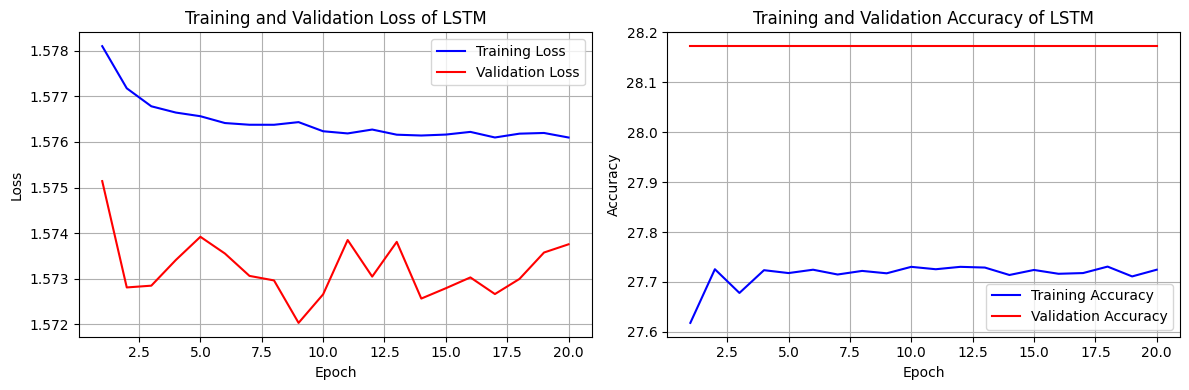

In [83]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of LSTM')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of LSTM')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### GRU Model

In [84]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [85]:
input_size = 300
hidden_size = 128
output_size = 5
num_layers = 8

model = GRUModel(input_size, hidden_size, output_size, num_layers)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [86]:
train_losses = []
val_losses = []
test_losses = []

train_accuracy = []
val_accuracy = []
test_accuracy = []

num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += calculate_accuracy(outputs, batch_y)
    
    model.eval()
    val_loss = 0
    val_acc = 0

    test_acc = 0
    test_loss = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            val_outputs = model(batch_x)
            val_loss += loss_function(val_outputs, batch_y).item()
            val_acc += calculate_accuracy(val_outputs, batch_y)

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            test_outputs = model(batch_x)
            test_loss += loss_function(test_outputs, batch_y).item()
            test_acc += calculate_accuracy(test_outputs, batch_y)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    val_losses.append(val_loss)
    val_accuracy.append(val_acc)

    test_losses.append(test_loss)
    test_accuracy.append(test_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Epoch 1/15
Train Loss: 1.2916, Train Accuracy: 44.04%
Validation Loss: 2.0680, Validation Accuracy: 22.83%
Test Loss: 2.0680, Test Accuracy: 22.83%
Epoch 2/15
Train Loss: 1.0454, Train Accuracy: 57.46%
Validation Loss: 2.2655, Validation Accuracy: 20.76%
Test Loss: 2.2655, Test Accuracy: 20.76%
Epoch 3/15
Train Loss: 0.9233, Train Accuracy: 64.15%
Validation Loss: 2.3254, Validation Accuracy: 25.94%
Test Loss: 2.3254, Test Accuracy: 25.94%
Epoch 4/15
Train Loss: 0.8703, Train Accuracy: 66.66%
Validation Loss: 2.2842, Validation Accuracy: 21.54%
Test Loss: 2.2842, Test Accuracy: 21.54%
Epoch 5/15
Train Loss: 0.8235, Train Accuracy: 69.17%
Validation Loss: 2.2157, Validation Accuracy: 24.07%
Test Loss: 2.2157, Test Accuracy: 24.07%
Epoch 6/15
Train Loss: 0.7732, Train Accuracy: 71.54%
Validation Loss: 2.3610, Validation Accuracy: 23.81%
Test Loss: 2.3610, Test Accuracy: 23.81%
Epoch 7/15
Train Loss: 0.7685, Train Accuracy: 71.77%
Validation Loss: 2.0584, Validation Accuracy: 25.60%
Test 

In [89]:
gru_train_accuracy = max(train_accuracy)
gru_val_accuracy = max(val_accuracy)
gru_test_accuracy = max(test_accuracy)

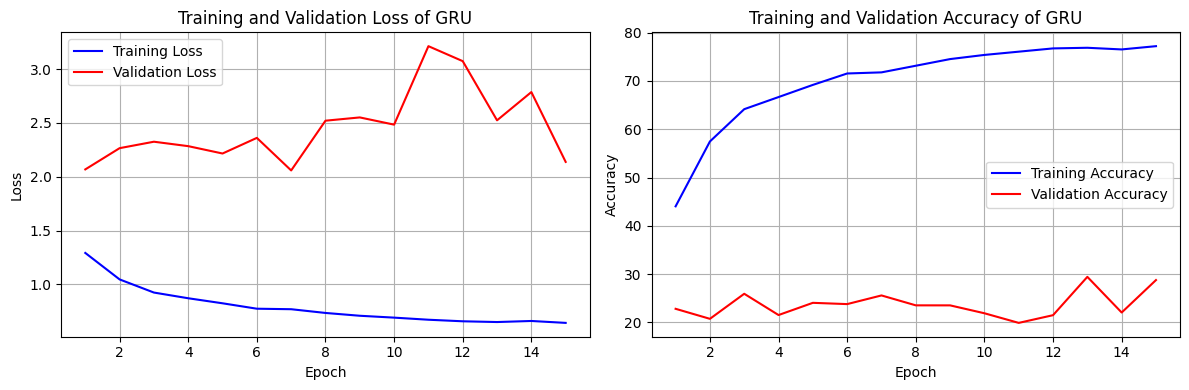

In [87]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of GRU')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of GRU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Comapre the models